In [2]:
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 200)
rng = np.random.default_rng(42)

In [3]:
path = Path("/Users/ananyashukla/Kaggle/Causal Impact of Product Feature on Retention/criteo-uplift-v2.1.csv")  # set your file path
df = pd.read_csv(path)
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [4]:
# Covariate balance snapshop (pre-adjustment)

def std_diff(a, b):
    mu_a, mu_b = a.mean(), b.mean()
    s2 = (a.var(ddof=1)+b.var(ddof=1))/2
    return 0.0 if s2==0 else (mu_a-mu_b)/np.sqrt(s2)

covars = [f"f{i}" for i in range(12)]
treated, control = df[df.treatment==1], df[df.treatment==0]
smd = pd.Series({c: abs(std_diff(treated[c], control[c])) for c in covars}).sort_values(ascending=False)
pd.DataFrame({"abs_SMD": smd, "treated_mean": treated[covars].mean(), "control_mean": control[covars].mean()}).head(12)

,abs_SMD,treated_mean,control_mean
f0,0.006866,19.614755,19.651705
f1,0.023994,10.070337,10.067935
f10,0.010563,5.333660,5.331898
f11,0.005160,-0.170985,-0.170868
f2,0.006241,8.446302,8.448173
f3,0.048836,4.169412,4.232821
f4,0.007966,10.339245,10.336526
f5,0.030557,4.026602,4.039339
f6,0.040448,-4.182792,-3.999880
f7,0.021270,5.105555,5.080284


Propensity AUC: 0.509


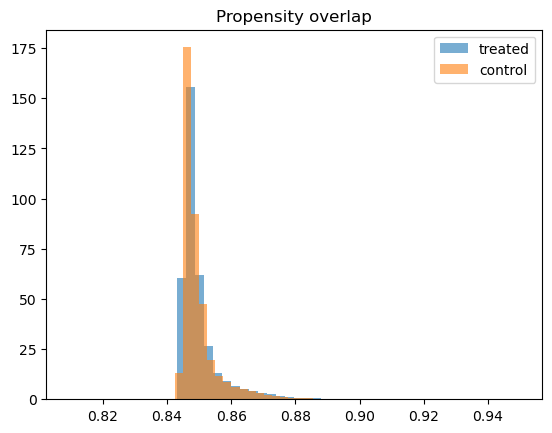

In [5]:
# Propensity scores (only pre-treatment covariates)

X = df[covars].values
t = df["treatment"].values

ps_model = LogisticRegression(max_iter=2000, solver="lbfgs")
ps_model.fit(X, t)
ps = ps_model.predict_proba(X)[:,1]
df["ps"] = ps

print("Propensity AUC:", round(roc_auc_score(t, ps), 3))
plt.figure(); 
plt.hist(ps[df.treatment==1], bins=50, alpha=0.6, density=True, label="treated");
plt.hist(ps[df.treatment==0], bins=50, alpha=0.6, density=True, label="control");
plt.title("Propensity overlap"); plt.legend(); plt.show();

In [6]:
# Overlap trimming

trim = (df.ps>=0.05) & (df.ps<=0.95)
df_trim = df.loc[trim].copy().reset_index(drop=True)
df_trim.shape, df.shape

((13979592, 17), (13979592, 17))

In [7]:
# IPTW ATE with stabilized weights + robust SE

p_t = df_trim["treatment"].mean()
eps = 1e-6
sw = np.where(df_trim.treatment==1, p_t/(df_trim.ps+eps), (1-p_t)/(1-df_trim.ps+eps))
y = df_trim["conversion"].values
T = df_trim["treatment"].values

Xw = sm.add_constant(T)
wls = sm.WLS(y, Xw, weights=sw)
res = wls.fit(cov_type="HC1")
ate = res.params[1]; se = res.bse[1]
print({"ATE_IPTW": round(ate,4), "SE": round(se,4), "N": len(df_trim)})

{'ATE_IPTW': 0.0009, 'SE': 0.0, 'N': 13979592}


In [8]:
# Doubly-robust AIPW (adds outcome models)

# outcome models P(Y=1|X,T)
clf_t = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_c = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)

Xt = df_trim.loc[df_trim.treatment==1, covars].values
Xc = df_trim.loc[df_trim.treatment==0, covars].values
yt = df_trim.loc[df_trim.treatment==1, "conversion"].values
yc = df_trim.loc[df_trim.treatment==0, "conversion"].values

clf_t.fit(Xt, yt); clf_c.fit(Xc, yc)

mu1 = clf_t.predict_proba(df_trim[covars].values)[:,1]
mu0 = clf_c.predict_proba(df_trim[covars].values)[:,1]

ps = df_trim["ps"].values
Y = df_trim["conversion"].values
T = df_trim["treatment"].values

term_t = T*(Y-mu1)/np.clip(ps,1e-6,1-1e-6) + mu1
term_c = (1-T)*(Y-mu0)/np.clip(1-ps,1e-6,1-1e-6) + mu0
ate_aipw = (term_t - term_c).mean()

print({"ATE_AIPW": round(ate_aipw,4)})

{'ATE_AIPW': 0.0009}


In [9]:
# 1-NN matching on propensity (ATT)

from sklearn.neighbors import NearestNeighbors
dft = df_trim.sort_values("ps").reset_index(drop=True)
ti = dft.index[dft.treatment==1]
ci = dft.index[dft.treatment==0]

nn = NearestNeighbors(n_neighbors=1).fit(dft.loc[ci, ["ps"]].values)
_, idx = nn.kneighbors(dft.loc[ti, ["ps"]].values)
matched_c = ci[idx.ravel()]
att = (dft.loc[ti, "conversion"].values - dft.loc[matched_c, "conversion"].values).mean()
print({"ATT_match": round(att,4), "treated_n": len(ti)})

{'ATT_match': 0.0009, 'treated_n': 11882655}


Avg CATE: 0.001
Policy treat rate (top 20% CATE): 0.9798987953393017


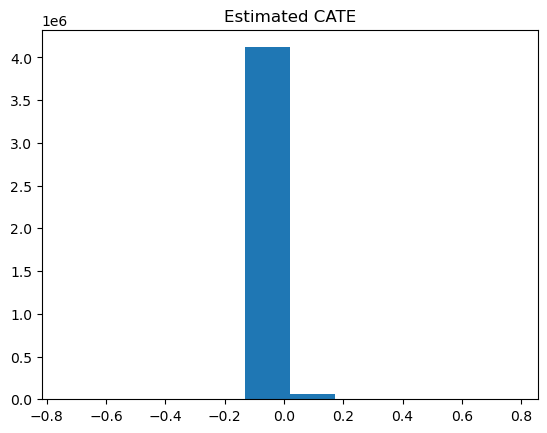

In [10]:
# Hetrogeneous effects (T-learner on probabilities)

train, test = train_test_split(df_trim, test_size=0.3, random_state=42, stratify=df_trim["treatment"])
X1 = train.loc[train.treatment==1, covars]; y1 = train.loc[train.treatment==1, "conversion"]
X0 = train.loc[train.treatment==0, covars]; y0 = train.loc[train.treatment==0, "conversion"]

m1 = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1).fit(X1, y1)
m0 = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1).fit(X0, y0)

p1 = m1.predict_proba(test[covars])[:,1]
p0 = m0.predict_proba(test[covars])[:,1]
cate = p1 - p0

print("Avg CATE:", round(cate.mean(),4))
thr = np.quantile(cate, 0.8)
policy = (cate>=thr).astype(int)
print("Policy treat rate (top 20% CATE):", policy.mean())

plt.figure(); plt.hist(cate, bins=10); plt.title("Estimated CATE"); plt.show()

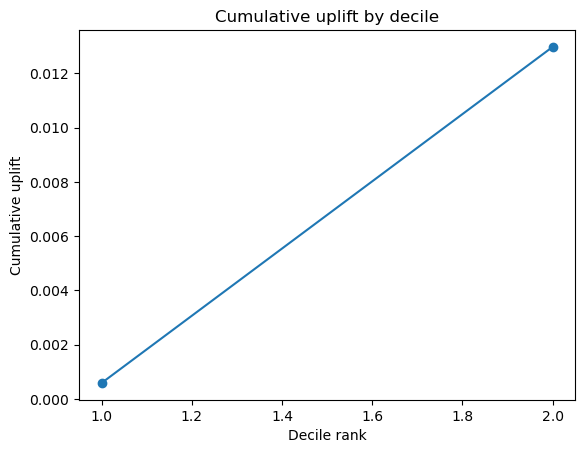

In [11]:
# Simple uplift curve by deciles

dec = pd.qcut(cate, 10, labels=False, duplicates="drop")
tmp = pd.DataFrame({"dec": dec, "y": test["conversion"].values, "t": test["treatment"].values})
curve = []
cum = 0.0
for d in sorted(tmp.dec.unique()):
    g = tmp[tmp.dec==d]
    lift = g[g.t==1].y.mean() - g[g.t==0].y.mean()
    cum += lift
    curve.append(cum)

plt.figure(); plt.plot(range(1,len(curve)+1), curve, marker="o"); 
plt.title("Cumulative uplift by decile"); plt.xlabel("Decile rank"); plt.ylabel("Cumulative uplift"); plt.show()

In [12]:
# IV (2-stage) for noncompliance using exposure if present

if "exposure" in df.columns:
    df_iv = df.copy().dropna(subset=["exposure"])
    for c in ["treatment","exposure","conversion"]:
        df_iv[c] = df_iv[c].astype(int)

    # First stage: exposure ~ treatment + X
    fs = smf.ols("exposure ~ treatment + " + " + ".join(covars), data=df_iv).fit(cov_type="HC1")
    df_iv["exp_hat"] = fs.fittedvalues

    # Second stage: conversion ~ exp_hat + X (linear probability model)
    ss = smf.ols("conversion ~ exp_hat + " + " + ".join(covars), data=df_iv).fit(cov_type="HC1")
    print(ss.summary().tables[1])
    print("LATE (coef on exp_hat):", round(ss.params["exp_hat"],4))
else:
    print("No 'exposure' column → skipping IV.")

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2810      0.008    -34.336      0.000      -0.297      -0.265
exp_hat        0.0282      0.001     28.393      0.000       0.026       0.030
f0          2.792e-05   4.28e-06      6.520      0.000    1.95e-05    3.63e-05
f1             0.0032      0.001      4.901      0.000       0.002       0.004
f2            -0.0010   6.76e-05    -14.308      0.000      -0.001      -0.001
f3         -1.993e-06   3.97e-05     -0.050      0.960   -7.99e-05    7.59e-05
f4             0.0391      0.000     81.072      0.000       0.038       0.040
f5            -0.0012      0.000     -5.555      0.000      -0.002      -0.001
f6         -1.697e-05   6.34e-06     -2.678      0.007   -2.94e-05   -4.55e-06
f7            -0.0002   5.42e-05     -4.515      0.000      -0.000      -0.000
f8            -0.0036      0.001     -5.680      0.0

In [13]:
# Sensitivity sketch and business readout

# crude Γ scan: perturb PS to mimic hidden bias
Gammas = [1.0, 1.25, 1.5, 2.0]
ates = []
ps0 = df_trim["ps"].values.copy()
for G in Gammas:
    adj = np.clip(ps0*G/(ps0*G + (1-ps0)), 1e-6, 1-1e-6)
    sw_adj = np.where(df_trim.treatment==1, p_t/adj, (1-p_t)/(1-adj))
    resG = sm.WLS(df_trim["conversion"], sm.add_constant(df_trim["treatment"]), weights=sw_adj).fit(cov_type="HC1")
    ates.append(resG.params[1])
print({f"Gamma_{g}": round(a,4) for g,a in zip(Gammas, ates)})

def business_readout(ate, population=1_000_000, value_per_conv=5.0):
    incr_conversions = ate * population
    incr_value = incr_conversions * value_per_conv
    return {"ATE": round(ate,4), "Incr_conversions": int(incr_conversions), "Incr_$": round(incr_value,2)}

print(business_readout(ate, population=500_000, value_per_conv=10.0))

{'Gamma_1.0': 0.0009, 'Gamma_1.25': 0.0009, 'Gamma_1.5': 0.0009, 'Gamma_2.0': 0.0009}
{'ATE': 0.0009, 'Incr_conversions': 467, 'Incr_$': 4673.43}
